# Brain Tumor MRI Prediction with PyTorch Tutorial
https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [163]:
import numpy as np
import pandas as pd
import glob
import os
import cv2
import time
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image 
from tempfile import TemporaryDirectory
from sklearn.metrics import confusion_matrix, accuracy_score
from torchvision import models, transforms, datasets
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
from torch.optim import lr_scheduler

In [126]:
#Directory path
root_path = './data'

#Set device
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

#Recommended mean and std
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

#Variables
batch_size = 4

Using mps device


In [127]:
#Set Transform
data_transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

In [149]:
#Load images
image_ds = datasets.ImageFolder(os.path.join(root_path), data_transform)

#Split dataset
train_size = int(0.75 * len(image_ds))  #75% for training
val_size = len(image_ds) - train_size  #25% for testing
train_ds, val_ds = random_split(image_ds, [train_size, test_size])

#Set dataloader
dataloaders = {
    'train': DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=0),
    'val': DataLoader(val_ds, batch_size=4, shuffle=False, num_workers=0)
}
dataset_sizes = {'train': len(train_ds), 'val': len(test_ds)}

#Check dataset sizes and classes
print(f'Train size: {len(train_ds)}, Val size: {len(test_ds)}')
print(f'names of classes: {class_names}')

Train size: 189, Val size: 64
names of classes: ['no', 'yes']


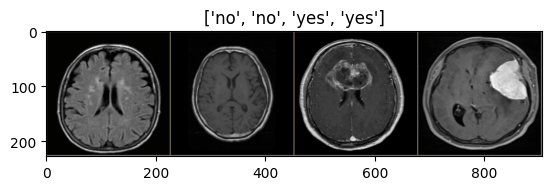

In [129]:
#Visualizing
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [164]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    writer = SummaryWriter(log_dir='runs/transfer_learning')
    
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.to(torch.float) / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                
                writer.add_scalar(f'Loss/{phase}', epoch_loss, epoch) 
                writer.add_scalar(f'Accuracy/{phase}', epoch_acc, epoch)

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))

    writer.close()
    return model


In [165]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [166]:
model_ft = models.resnet18(weights = "IMAGENET1K_V1")
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [167]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.8447 Acc: 0.6772
val Loss: 0.6039 Acc: 0.7812

Epoch 1/24
----------
train Loss: 0.5209 Acc: 0.7672
val Loss: 0.3182 Acc: 0.8750

Epoch 2/24
----------
train Loss: 0.4415 Acc: 0.8307
val Loss: 0.3042 Acc: 0.9062

Epoch 3/24
----------
train Loss: 0.2839 Acc: 0.8730
val Loss: 0.4798 Acc: 0.7656

Epoch 4/24
----------
train Loss: 0.3596 Acc: 0.8730
val Loss: 0.3719 Acc: 0.8594

Epoch 5/24
----------
train Loss: 0.4545 Acc: 0.8360
val Loss: 0.2941 Acc: 0.8750

Epoch 6/24
----------
train Loss: 0.4967 Acc: 0.8677
val Loss: 0.3498 Acc: 0.8438

Epoch 7/24
----------
train Loss: 0.1684 Acc: 0.9418
val Loss: 0.3889 Acc: 0.8438

Epoch 8/24
----------
train Loss: 0.1123 Acc: 0.9418
val Loss: 0.3572 Acc: 0.8438

Epoch 9/24
----------
train Loss: 0.1221 Acc: 0.9524
val Loss: 0.2998 Acc: 0.8906

Epoch 10/24
----------
train Loss: 0.1588 Acc: 0.9312
val Loss: 0.3362 Acc: 0.8594

Epoch 11/24
----------
train Loss: 0.0855 Acc: 0.9735
val Loss: 0.2789 Acc: 0.8750

Ep

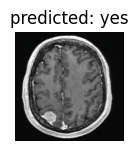

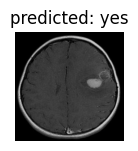

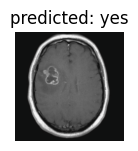

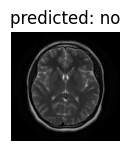

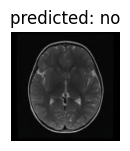

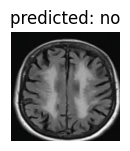

In [160]:
visualize_model(model_ft)


In [168]:
#tensorboard --logdir=runs